In [97]:
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.dataprocessing.transformers import (
    BoxCox,
    MissingValuesFiller,
)
from darts.utils.timeseries_generation import gaussian_timeseries, random_walk_timeseries, sine_timeseries


# Time Series Preprocessing with Darts

This notebook demonstrates the process of preprocessing time series data using the Darts library. We focus on handling missing values and removing outliers from a synthetic "dirty" time series.

## Steps

1. **Generate Dirty Data**: We start with a synthetic time series that includes missing values and outliers.

2. **Initial Missing Value Imputation**: We use `MissingValuesFiller` to fill in initial missing values.

3. **Outlier Removal**: We implement a custom function to remove outliers based on Z-scores.

4. **Final Missing Value Imputation**: After removing outliers, we fill in the newly created gaps.

## Key Functions

### `remove_outliers(ts, threshold=3)`

This function removes outliers from a TimeSeries object using the Z-score method:
- `ts`: Input TimeSeries
- `threshold`: Z-score threshold for outlier detection (default: 3)

## Visualizations

### Time Series Plots

We visualize the time series at four stages:
1. Original dirty series
2. Series after initial missing value imputation
3. Series after outlier removal
4. Final series after filling gaps created by outlier removal

### Histograms

We use histograms to visualize the distribution of values at each stage of preprocessing:

1. **Original Distribution**: Shows the distribution of the original dirty data. This may include outliers and might be skewed or have multiple peaks due to the presence of anomalies.

2. **Distribution After Initial Filling**: Displays how the initial missing value imputation affects the data distribution. The shape might be similar to the original, but with more data points filled in.

3. **Distribution After Outlier Removal**: This histogram should show a more concentrated distribution, with extreme values (outliers) removed. The tails of the distribution should be less pronounced compared to the previous stages.

4. **Final Distribution**: Represents the data distribution after all preprocessing steps. This should be the cleanest distribution, with outliers removed and all missing values filled. It should closely represent the true underlying distribution of the data.

The histograms help us understand how each preprocessing step affects the overall distribution of our data. They can reveal:
- The impact of outliers on the data spread
- How missing value imputation changes the data distribution
- The effectiveness of our outlier removal process
- Any potential biases introduced by our preprocessing steps

By comparing these histograms, we can ensure that our preprocessing maintains the important characteristics of our data while removing unwanted noise and anomalies.

## Statistics

We provide statistics on:
- The length of the series at each stage
- The number and percentage of outliers removed

These statistics help quantify the impact of our preprocessing steps on the data.

### Config for the Time Series sysnthetic data

In [98]:
np.random.seed(42)

start_date = '2023-01-01'
end_date = '2023-12-31'
frequency = 'D'

missing_start  = '2023-03-01'
missing_end = '2023-03-15'

outlier_start = '2023-06-01'
outlier_end = '2023-06-05'


noise_std = 0.4
seasonality_frequency = 1/365

### Generating the dirty data


In [99]:
def generate_dirty_data(
    start_date: str = start_date,
    end_date: str = end_date,
    frequency: str = frequency,
    missing_start: str = missing_start,
    missing_end: str = missing_end,
    outlier_start: str = outlier_start,
    outlier_end: str = outlier_end,
    outlier_multiplier: float = 10.0,
    noise_std: float = noise_std,
    seasonality_frequency: float = seasonality_frequency
) -> Tuple[TimeSeries, Dict[str, np.ndarray]]:
    """
    Generate a 'dirty' time series with trend, seasonality, noise, missing values, and outliers.

    This function creates a time series using components from Darts' timeseries generation
    utilities, then introduces missing values and outliers to simulate real-world data issues.

    Parameters:
    -----------
    start_date : str, optional
        The start date of the time series (default is '2023-01-01')
    end_date : str, optional
        The end date of the time series (default is '2023-12-31')
    frequency : str, optional
        The frequency of the time series (default is 'D' for daily)
    missing_start : str, optional
        The start date for introducing missing values (default is '2023-03-01')
    missing_end : str, optional
        The end date for introducing missing values (default is '2023-03-15')
    outlier_start : str, optional
        The start date for introducing outliers (default is '2023-06-01')
    outlier_end : str, optional
        The end date for introducing outliers (default is '2023-06-05')
    outlier_multiplier : float, optional
        The multiplier for creating outliers (default is 10.0)
    noise_std : float, optional
        The standard deviation of the noise component (default is 0.1)
    seasonality_frequency : float, optional
        The frequency of the seasonal component (default is 1/365 for yearly seasonality)

    Returns:
    --------
    Tuple[TimeSeries, Dict[str, np.ndarray]]
        A tuple containing:
        - The generated 'dirty' time series as a Darts TimeSeries object
        - A dictionary of static covariates (currently only 'is_weekend')

     Example:
    --------
    >>> dirty_series, static_covs = generate_dirty_data()
    >>> print(f"Generated time series from {dirty_series.start_time()} to {dirty_series.end_time()}")
    >>> print(f"Total points: {len(dirty_series)}")
    >>> print(f"Missing values: {dirty_series.gaps().size}")
    >>> print(f"Static covariates: {list(static_covs.keys())}")
    """

    # Convert string dates to pandas Timestamps
    start = pd.Timestamp(start_date)
    end = pd.Timestamp(end_date)

    # Generate components of the time series
    trend = random_walk_timeseries(start=start, end=end, freq=frequency)
    seasonality = sine_timeseries(start=start, end=end, freq=frequency, value_frequency=seasonality_frequency)
    noise = gaussian_timeseries(start=start, end=end, freq=frequency, std=noise_std)

    # Combine components
    series = trend + seasonality + noise

    # Introduce missing values
    missing_mask = (series.time_index >= pd.Timestamp(missing_start)) & (series.time_index <= pd.Timestamp(missing_end))
    values = series.values()
    values[missing_mask] = np.nan
    series = TimeSeries.from_times_and_values(series.time_index, values)

    # Introduce outliers
    outlier_mask = (series.time_index >= pd.Timestamp(outlier_start)) & (series.time_index <= pd.Timestamp(outlier_end))
    values = series.values()
    values[outlier_mask] *= outlier_multiplier
    series = TimeSeries.from_times_and_values(series.time_index, values)

    # Add static covariates
    static_covs = {'is_weekend': series.time_index.dayofweek.isin([5, 6]).astype(int)}

    return series, static_covs




### Visualize the dirty data


In [100]:

def visualize_dirty_data(series: TimeSeries, missing_start: str, missing_end: str, outlier_start: str, outlier_end: str):
    """
    Visualize the 'dirty' time series data, highlighting missing values and outliers.

    Parameters:
    -----------
    series : TimeSeries
        The Darts TimeSeries object to visualize
    missing_start : str
        The start date of the missing values period
    missing_end : str
        The end date of the missing values period
    outlier_start : str
        The start date of the outliers period
    outlier_end : str
        The end date of the outliers period
    """
    plt.figure(figsize=(15, 7))

    # Plot the main series
    series.plot(label='Time Series')

    # Highlight the missing values period
    plt.axvspan(pd.Timestamp(missing_start), pd.Timestamp(missing_end), color='red', alpha=0.3, label='Missing Values')

    # Highlight the outliers period
    plt.axvspan(pd.Timestamp(outlier_start), pd.Timestamp(outlier_end), color='green', alpha=0.3, label='Outliers')

    plt.title('Raw Time Series Data with Missing Values and Outliers')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Generated time series from 2023-01-01 00:00:00 to 2023-12-31 00:00:00
Total points: 365
Missing values: 3
Static covariates: ['is_weekend']


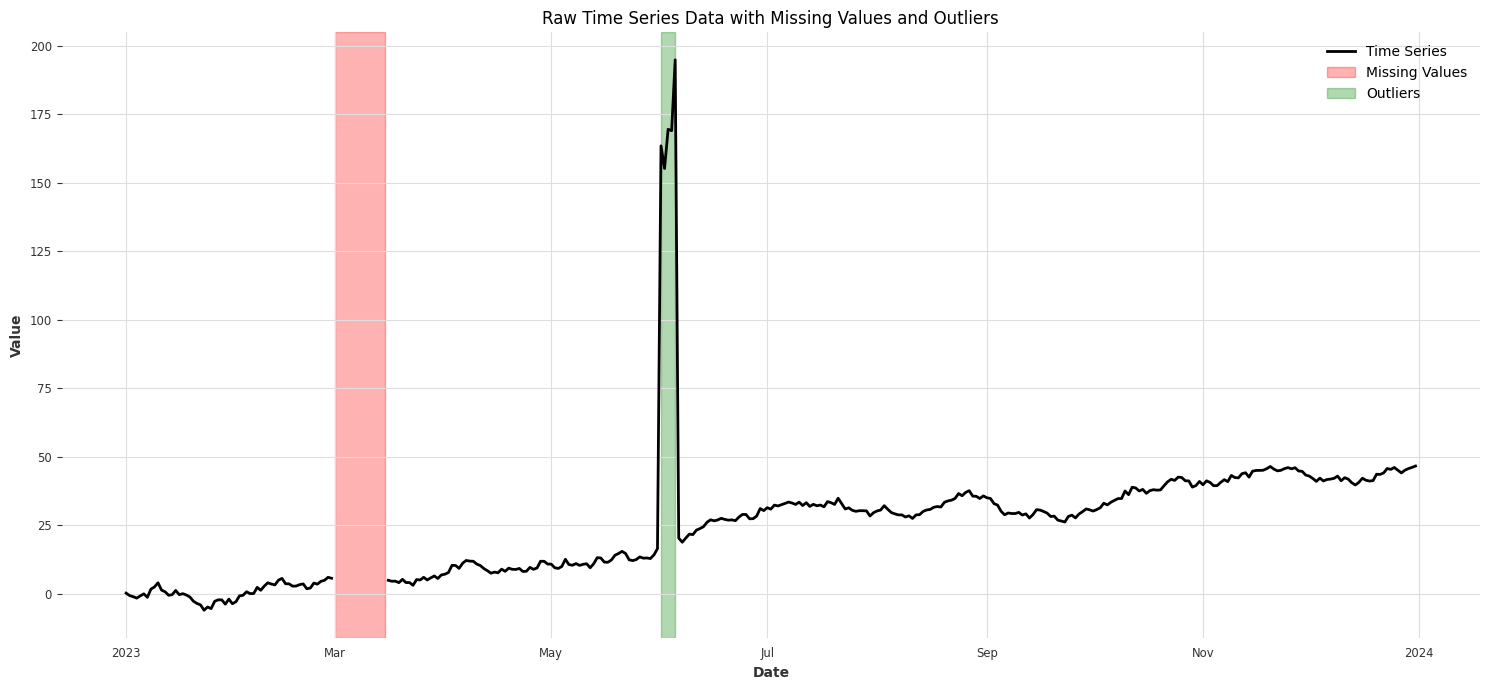

In [102]:
# Generate the dirty series
dirty_series, static_covs = generate_dirty_data()

# Print some information about the generated series
print(f"Generated time series from {dirty_series.start_time()} to {dirty_series.end_time()}")
print(f"Total points: {len(dirty_series)}")
print(f"Missing values: {dirty_series.gaps().size}")
print(f"Static covariates: {list(static_covs.keys())}")

# Visualize the dirty data
visualize_dirty_data(dirty_series, missing_start, missing_end, outlier_start, outlier_end)

### Handling missing values

This should give a very brief overview of the different methods to handle missing values in time series.

* For the 'Darts' library, the most important thing to note is that the `MissingValuesFiller` class is used to fill missing values.

    At the current stage, the `MissingValuesFiller` class only uses the fill argument as 'auto'.
    This is the basic imputation method of pandas found in the documentation [here](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.transformers.missing_values_filler.html#darts.dataprocessing.transformers.missing_values_filler.MissingValuesFiller) 
    ```
        fill
            The value used to replace the missing values.
            If set to 'auto', will auto-fill missing values using the :func:`pd.Dataframe.interpolate()` method.
    ```
* The remaining methods are from the 'pandas' library and are used to fill missing values in a DataFrame.
    

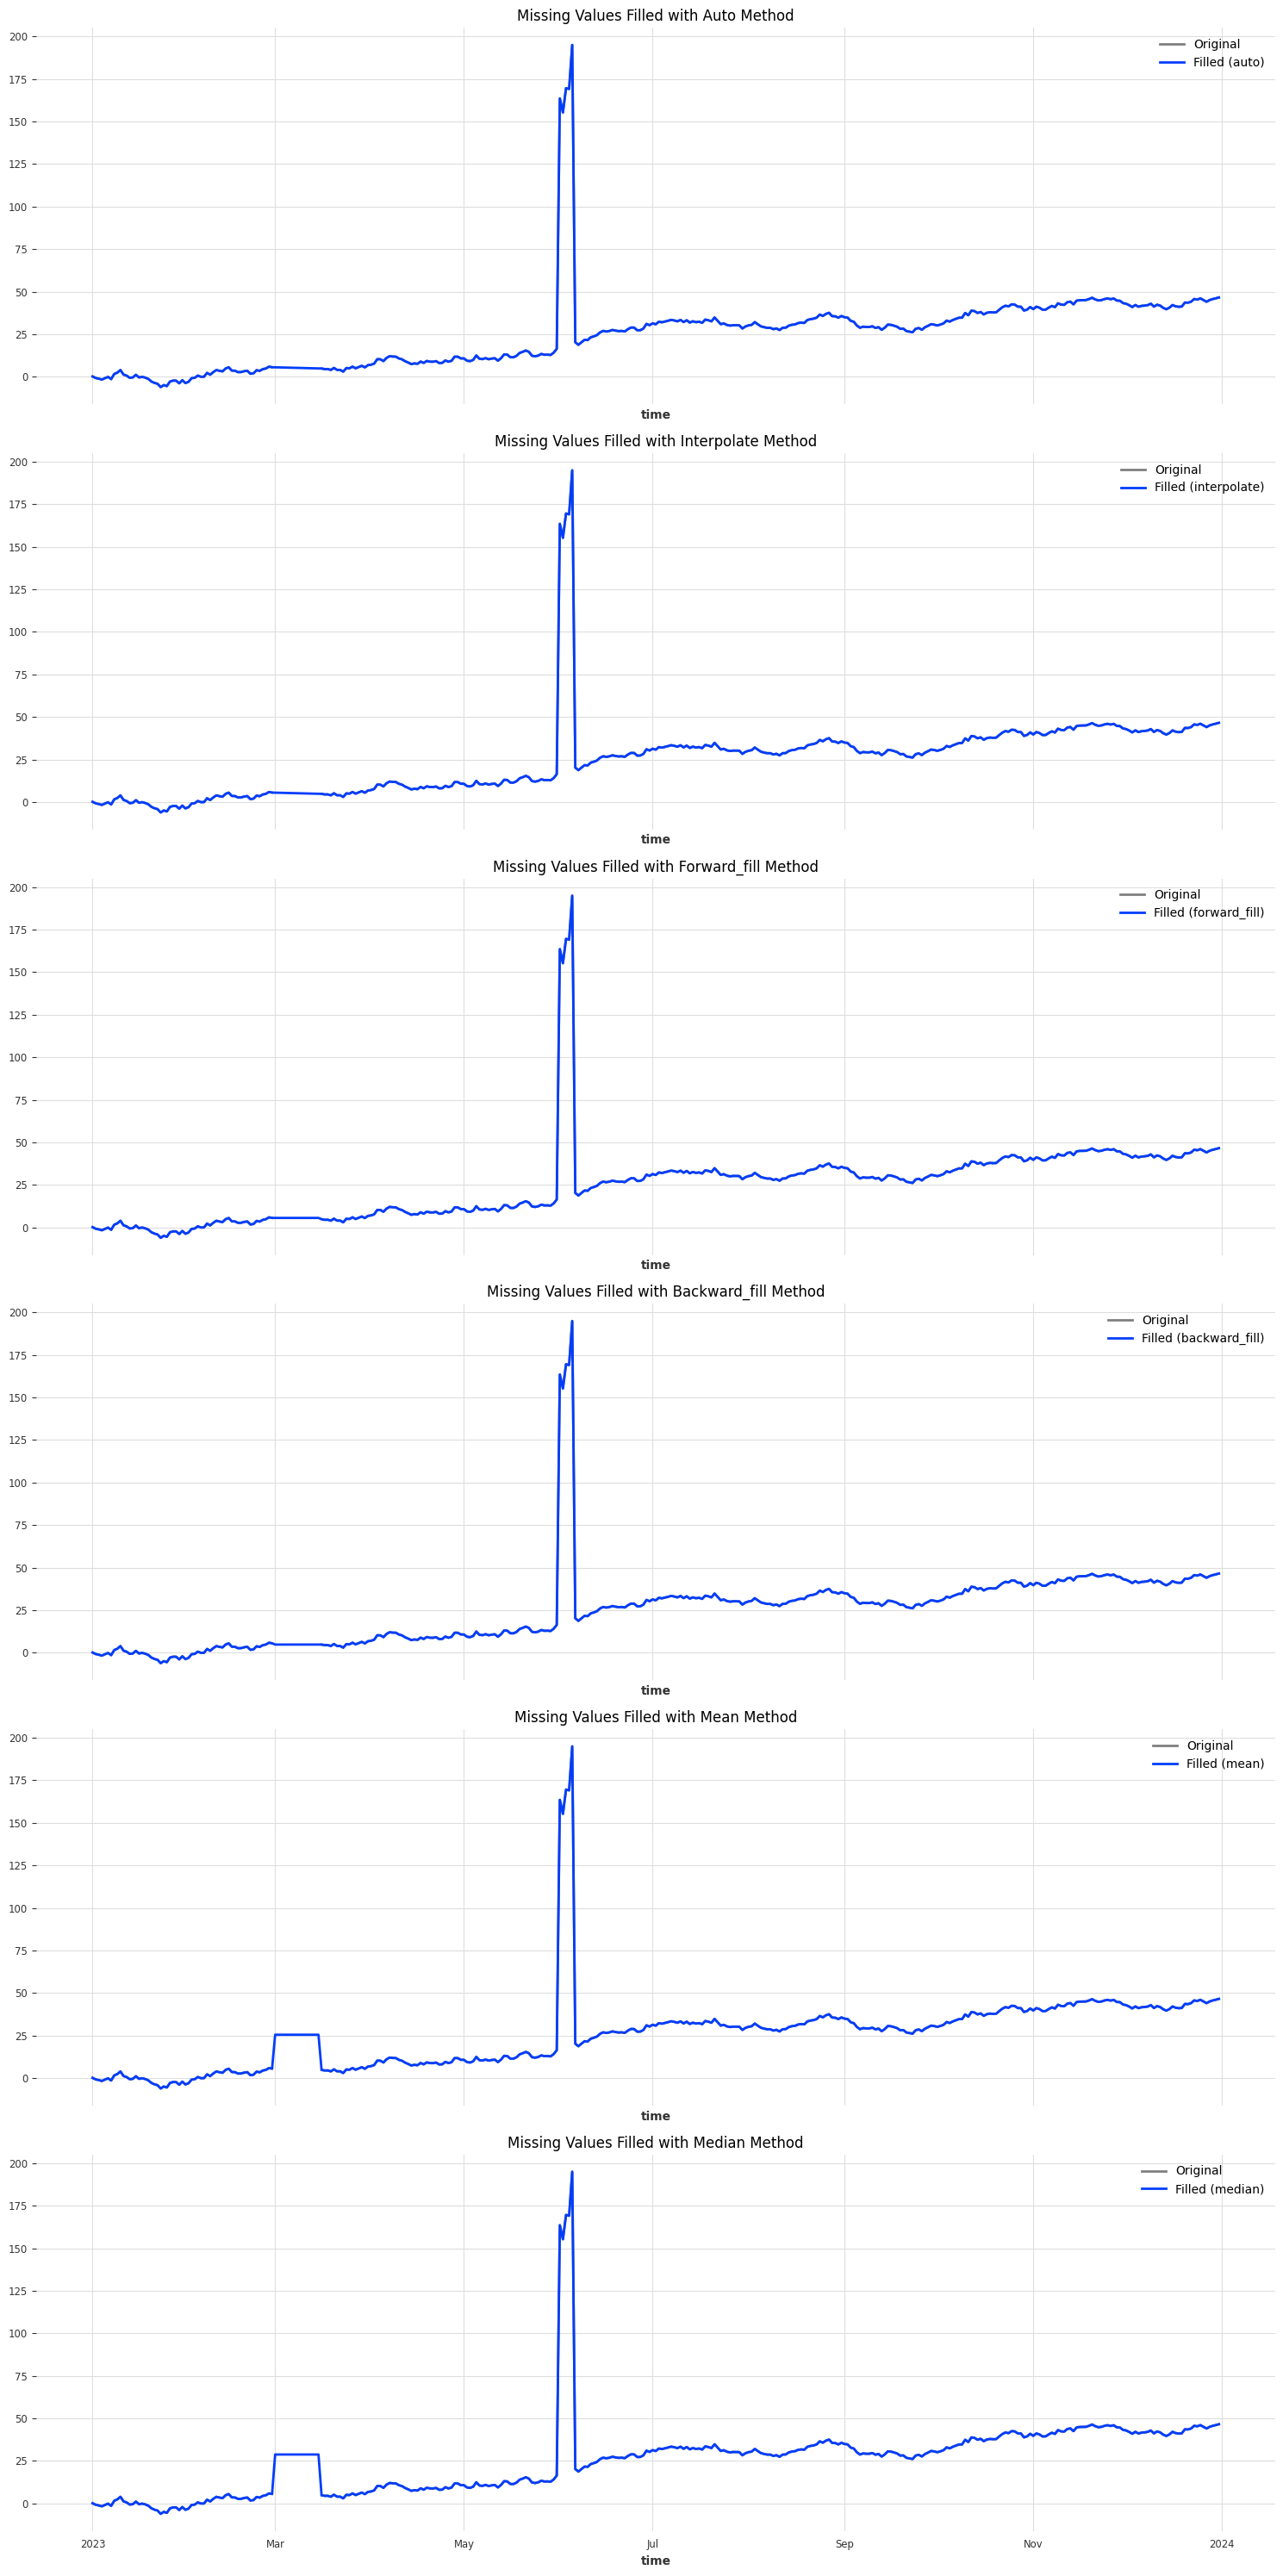

Missing values in each series:
Original: 3
Auto: 0
Interpolate: 0
Forward_fill: 0
Backward_fill: 0
Mean: 0
Median: 0


In [103]:
# Define filling methods
methods = ['auto', 'interpolate', 'forward_fill', 'backward_fill', 'mean', 'median']

# Create subplots
fig, axs = plt.subplots(len(methods), 1, figsize=(15, 5 * len(methods)), sharex=True)

# Apply and plot each filling method
for i, method in enumerate(methods):
    if method == 'auto':
        filler = MissingValuesFiller(fill='auto')
        filled_series = filler.transform(dirty_series)
    else:
        # Use pandas for other methods
        values = dirty_series.values()
        df = pd.DataFrame(values)
        if method == 'interpolate':
            filled_values = df.interpolate().values
        elif method == 'forward_fill':
            filled_values = df.ffill().values
        elif method == 'backward_fill':
            filled_values = df.bfill().values
        elif method == 'mean':
            filled_values = df.fillna(value=np.nanmean(values)).values
        elif method == 'median':
            filled_values = df.fillna(value=np.nanmedian(values)).values

        filled_series = TimeSeries.from_times_and_values(dirty_series.time_index, filled_values)

    # Plot original and filled series
    dirty_series.plot(ax=axs[i], label='Original', alpha=0.5)
    filled_series.plot(ax=axs[i], label=f'Filled ({method})')
    axs[i].set_title(f'Missing Values Filled with {method.capitalize()} Method')
    axs[i].legend()

plt.tight_layout()
plt.show()

# Print statistics
print("Missing values in each series:")
print(f"Original: {dirty_series.gaps().size}")
for method in methods:
    if method == 'auto':
        filler = MissingValuesFiller(fill='auto')
        filled_series = filler.transform(dirty_series)
    else:
        # Use pandas for other methods
        values = dirty_series.values()
        df = pd.DataFrame(values)
        if method == 'interpolate':
            filled_values = df.interpolate().values
        elif method == 'forward_fill':
            filled_values = df.ffill().values
        elif method == 'backward_fill':
            filled_values = df.bfill().values
        elif method == 'mean':
            filled_values = df.fillna(value=np.nanmean(values)).values
        elif method == 'median':
            filled_values = df.fillna(value=np.nanmedian(values)).values

        filled_series = TimeSeries.from_times_and_values(dirty_series.time_index, filled_values)

    print(f"{method.capitalize()}: {filled_series.gaps().size}")

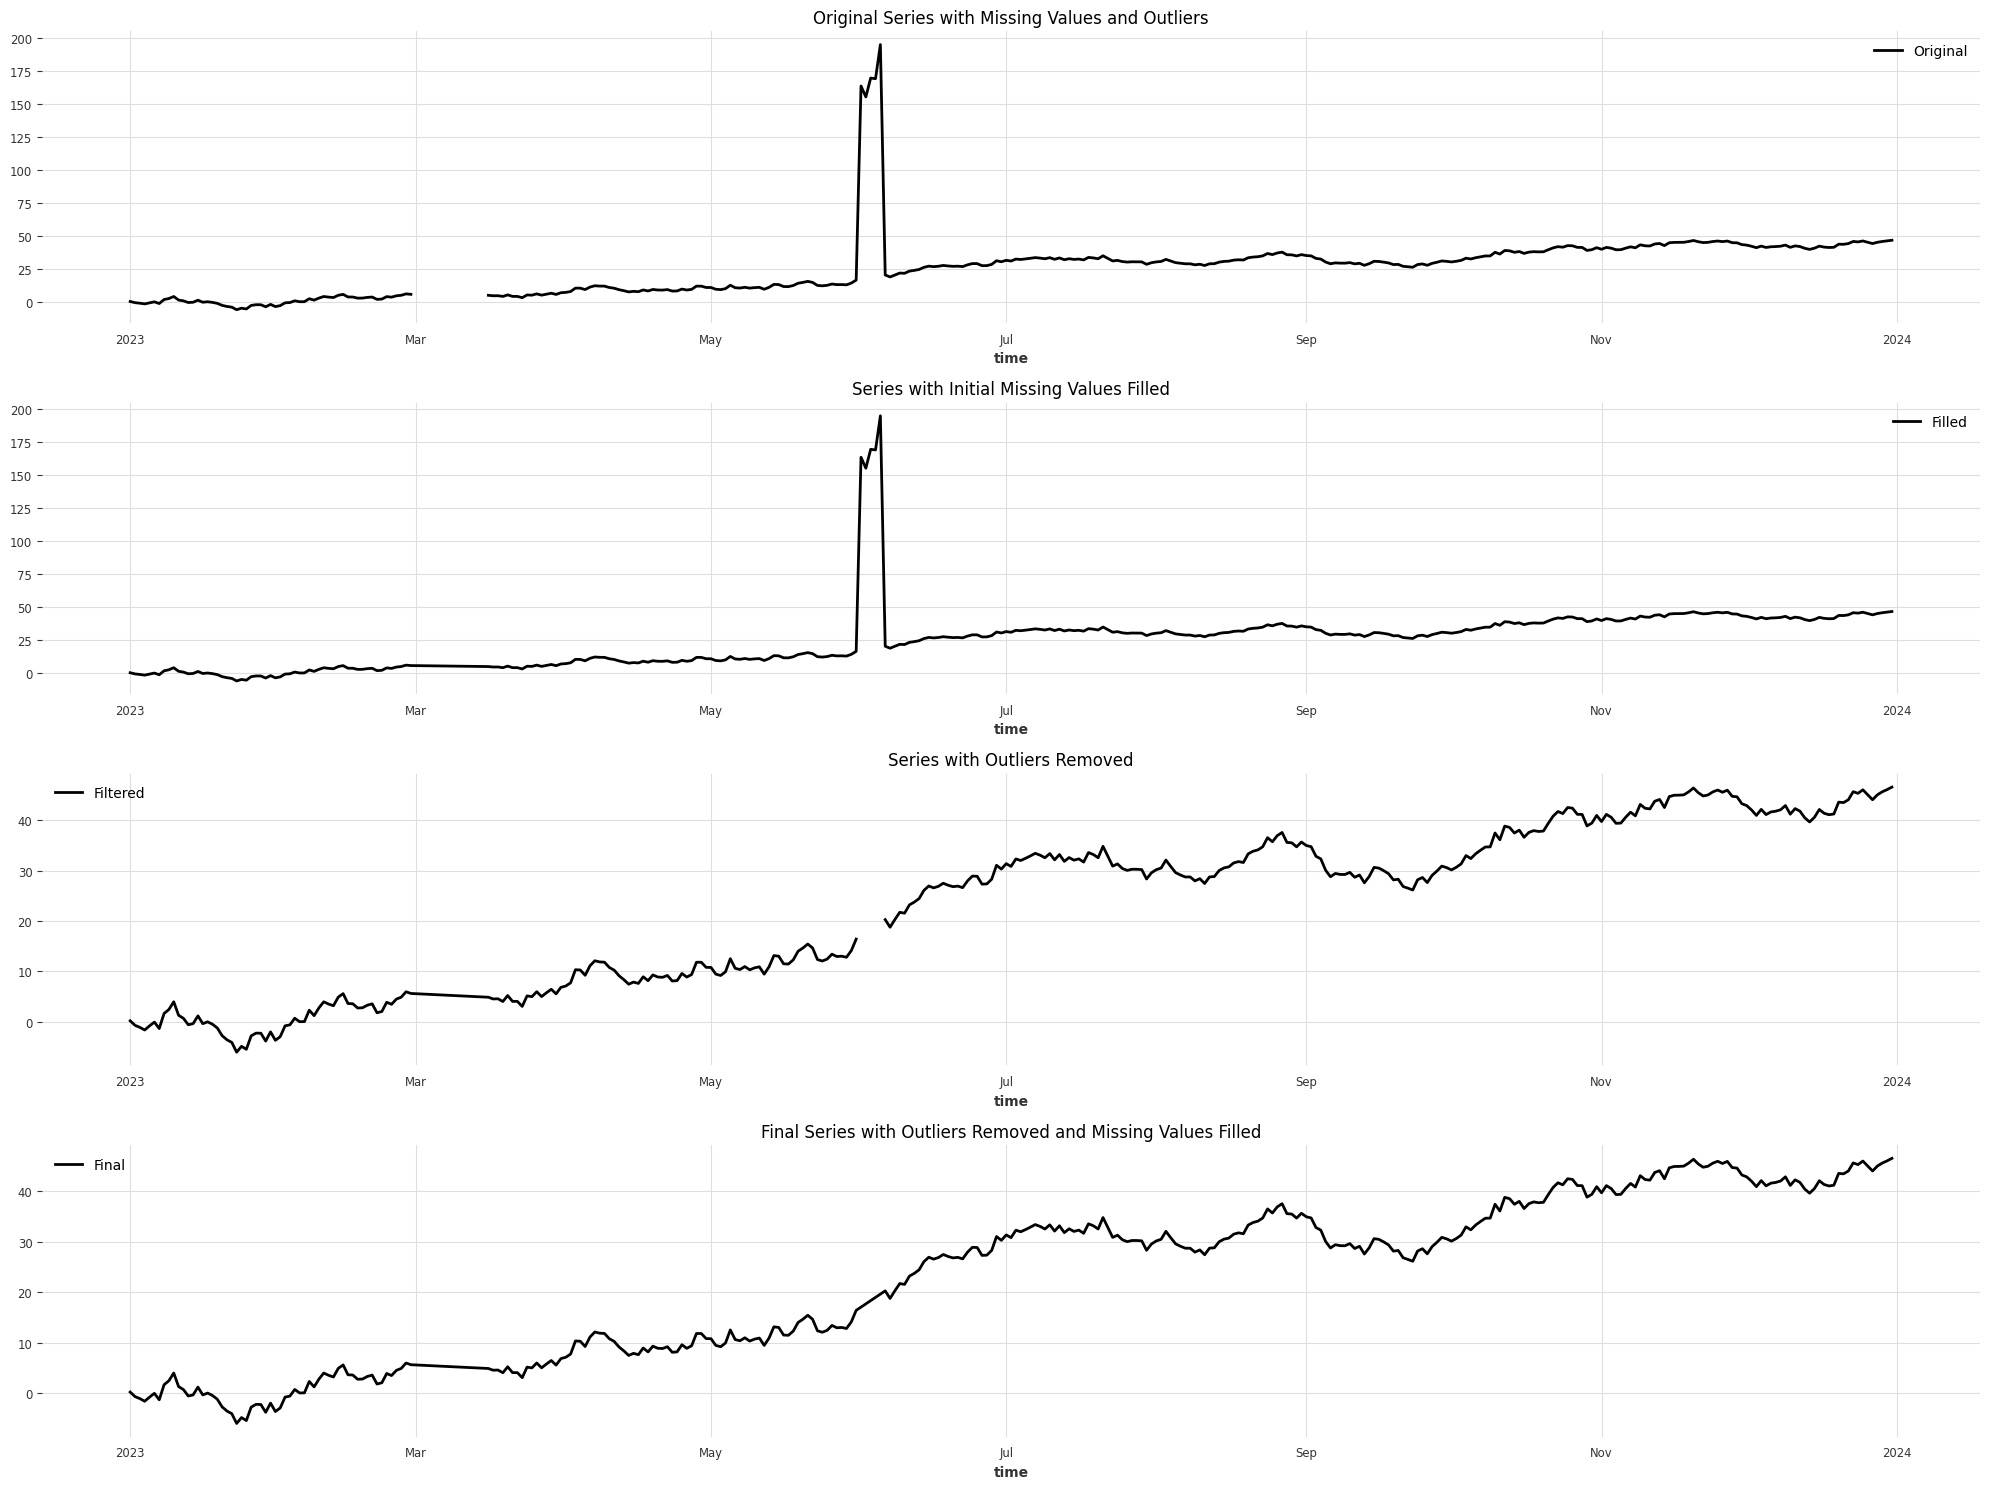

Original series length: 365
Initially filled series length: 365
Series length after outlier removal: 365
Final series length: 365
Number of outliers removed: 0
Percentage of data points identified as outliers: 0.00%


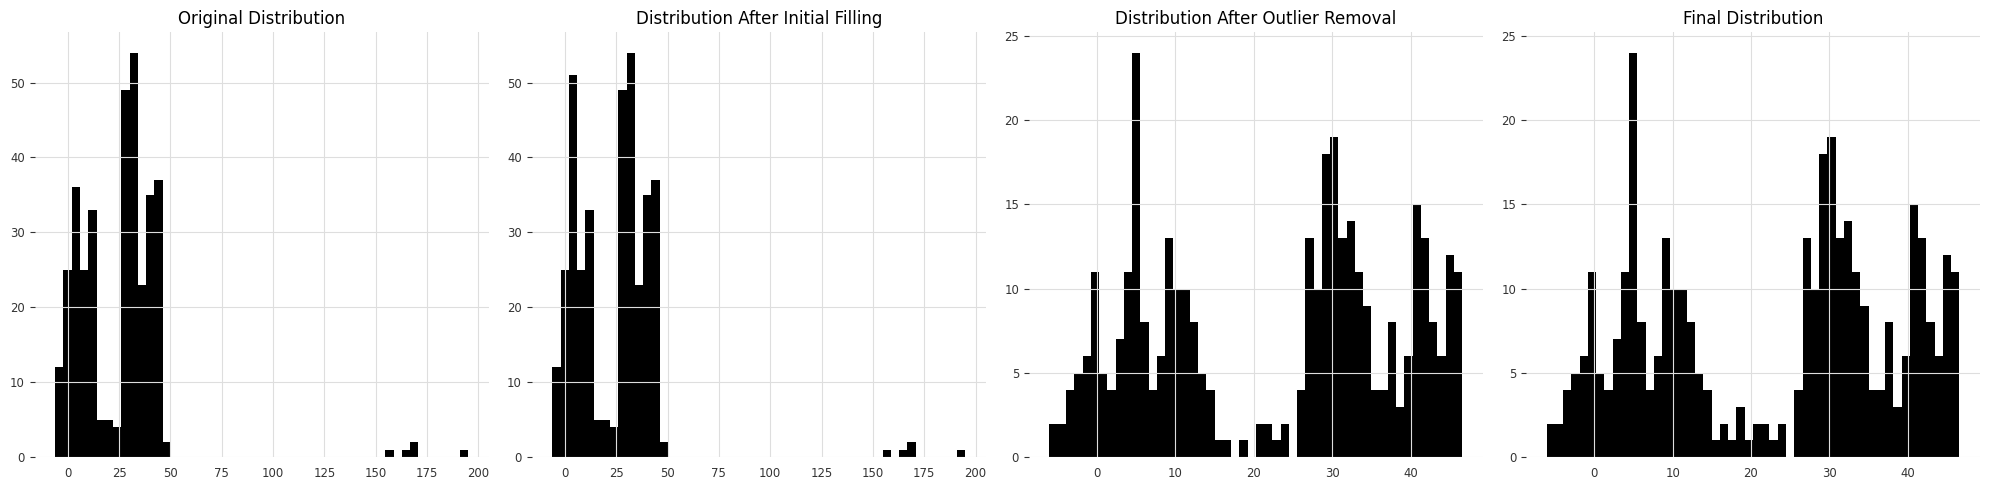

In [109]:

def remove_outliers(ts, threshold=3):
    """
    Remove outliers from a TimeSeries using Z-score.
    
    Args:
    ts (TimeSeries): Input TimeSeries
    threshold (float): Z-score threshold for outliers
    
    Returns:
    TimeSeries: TimeSeries with outliers removed
    """
    values = ts.values()
    z_scores = np.abs(stats.zscore(values))
    mask = z_scores < threshold
    filtered_values = values[mask]
    filtered_time_index = ts.time_index[mask.flatten()]
    return TimeSeries.from_times_and_values(
        filtered_time_index,
        filtered_values,
        freq=ts.freq_str
    )

# Remove outliers
filtered_series = remove_outliers(filled_series)

# Fill in missing values after outlier removal
filler = MissingValuesFiller(fill='auto')
final_series = filler.transform(filtered_series)

# Visualize the results
plt.figure(figsize=(20, 15))

plt.subplot(4, 1, 1)
dirty_series.plot(label='Original')
plt.title('Original Series with Missing Values and Outliers')
plt.legend()

plt.subplot(4, 1, 2)
filled_series.plot(label='Filled')
plt.title('Series with Initial Missing Values Filled')
plt.legend()

plt.subplot(4, 1, 3)
filtered_series.plot(label='Filtered')
plt.title('Series with Outliers Removed')
plt.legend()

plt.subplot(4, 1, 4)
final_series.plot(label='Final')
plt.title('Final Series with Outliers Removed and Missing Values Filled')
plt.legend()

plt.tight_layout()
plt.show()

# Print statistics
print("Original series length:", len(dirty_series))
print("Initially filled series length:", len(filled_series))
print("Series length after outlier removal:", len(filtered_series))
print("Final series length:", len(final_series))

# Calculate and print the number of outliers removed
outliers_removed = len(filled_series) - len(filtered_series)
print(f"Number of outliers removed: {outliers_removed}")
print(f"Percentage of data points identified as outliers: {outliers_removed/len(filled_series)*100:.2f}%")

# Plot the distribution of the data at different stages
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.hist(dirty_series.values().flatten(), bins=50)
plt.title('Original Distribution')

plt.subplot(1, 4, 2)
plt.hist(filled_series.values().flatten(), bins=50)
plt.title('Distribution After Initial Filling')

plt.subplot(1, 4, 3)
plt.hist(filtered_series.values().flatten(), bins=50)
plt.title('Distribution After Outlier Removal')

plt.subplot(1, 4, 4)
plt.hist(final_series.values().flatten(), bins=50)
plt.title('Final Distribution')

plt.tight_layout()
plt.show()

In [111]:

# Apply BoxCox transformation
box_cox = BoxCox()
box_cox_series = box_cox.fit_transform(final_series)

# Visualize the results
plt.figure(figsize=(20, 15))

plt.subplot(5, 1, 1)
dirty_series.plot(label='Original')
plt.title('Original Dirty Series')
plt.legend()

plt.subplot(5, 1, 2)
filled_series.plot(label='Filled')
plt.title('Series with Initial Missing Values Filled')
plt.legend()

plt.subplot(5, 1, 3)
filtered_series.plot(label='Filtered')
plt.title('Series with Outliers Removed')
plt.legend()

plt.subplot(5, 1, 4)
final_series.plot(label='Final')
plt.title('Series with Outliers Removed and Missing Values Filled')
plt.legend()

plt.subplot(5, 1, 5)
box_cox_series.plot(label='BoxCox')
plt.title('Series after BoxCox Transformation')
plt.legend()

plt.tight_layout()
plt.show()

# Plot the distribution of the data at different stages, including after BoxCox
plt.figure(figsize=(20, 5))

plt.subplot(1, 5, 1)
plt.hist(dirty_series.values().flatten(), bins=50)
plt.title('Original Distribution')

plt.subplot(1, 5, 2)
plt.hist(filled_series.values().flatten(), bins=50)
plt.title('After Initial Filling')

plt.subplot(1, 5, 3)
plt.hist(filtered_series.values().flatten(), bins=50)
plt.title('After Outlier Removal')

plt.subplot(1, 5, 4)
plt.hist(final_series.values().flatten(), bins=50)
plt.title('After Final Filling')

plt.subplot(1, 5, 5)
plt.hist(box_cox_series.values().flatten(), bins=50)
plt.title('After BoxCox Transformation')

plt.tight_layout()
plt.show()

# Print statistics
print("Original series statistics:")
print(dirty_series.describe())
print("\nFinal series statistics (before BoxCox):")
print(final_series.describe())
print("\nBoxCox transformed series statistics:")
print(box_cox_series.describe())

ValueError: The `x` argument of `boxcox_normmax` must contain only positive, finite, real numbers.

In [112]:
from darts.detectors import KMeansAnomalyDetector, LSTMAnomalyDetector, SimpleAnomalyDetector
from darts.models import ExponentialSmoothing

# Assuming we have our 'dirty_series' from previous steps

# 1. Simple Anomaly Detector
simple_detector = SimpleAnomalyDetector(k=2)  # k is the number of standard deviations
simple_anomalies = simple_detector.fit_detect(dirty_series)

# 2. KMeans Anomaly Detector
kmeans_detector = KMeansAnomalyDetector(k=2, window=5)  # k is the number of clusters
kmeans_anomalies = kmeans_detector.fit_detect(dirty_series)

# 3. LSTM Anomaly Detector
lstm_detector = LSTMAnomalyDetector(window=5, n_epochs=50, batch_size=32)
lstm_anomalies = lstm_detector.fit_detect(dirty_series)

# Visualize the results
plt.figure(figsize=(15, 20))

plt.subplot(4, 1, 1)
dirty_series.plot(label='Original Series')
plt.title('Original Dirty Series')
plt.legend()

plt.subplot(4, 1, 2)
dirty_series.plot(label='Original Series')
simple_anomalies.plot(label='Simple Anomalies', marker='o', linestyle='None')
plt.title('Simple Anomaly Detection')
plt.legend()

plt.subplot(4, 1, 3)
dirty_series.plot(label='Original Series')
kmeans_anomalies.plot(label='KMeans Anomalies', marker='o', linestyle='None')
plt.title('KMeans Anomaly Detection')
plt.legend()

plt.subplot(4, 1, 4)
dirty_series.plot(label='Original Series')
lstm_anomalies.plot(label='LSTM Anomalies', marker='o', linestyle='None')
plt.title('LSTM Anomaly Detection')
plt.legend()

plt.tight_layout()
plt.show()

# Print statistics
print("Number of anomalies detected:")
print(f"Simple Detector: {simple_anomalies.sum().sum()}")
print(f"KMeans Detector: {kmeans_anomalies.sum().sum()}")
print(f"LSTM Detector: {lstm_anomalies.sum().sum()}")

/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


ModuleNotFoundError: No module named 'darts.detectors'

ModuleNotFoundError: No module named 'darts.models.forecasting.stats_forecast_model'

In [114]:
import matplotlib.pyplot as plt
import numpy as np
from darts import TimeSeries
from darts.ad.anomaly_model import FilteringAnomalyModel, StatisticalAnomalyModel
from darts.dataprocessing.transformers import MissingValuesFiller
from darts.metrics import mape

# Assuming we have our 'dirty_series' from previous steps

# Fill missing values if any
filler = MissingValuesFiller()
filled_series = filler.transform(dirty_series)

# Create anomaly detection models
filtering_model = FilteringAnomalyModel(model=ExponentialSmoothing())
statistical_model = StatisticalAnomalyModel(method="IQR")

# Detect anomalies
filtering_anomalies = filtering_model.fit_detect(filled_series)
statistical_anomalies = statistical_model.fit_detect(filled_series)

# Visualize the results
plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
filled_series.plot(label='Original Series')
plt.title('Original Series (with filled missing values)')
plt.legend()

plt.subplot(3, 1, 2)
filled_series.plot(label='Original Series')
filtering_anomalies.plot(label='Filtering Anomalies', marker='o', linestyle='None')
plt.title('Filtering Anomaly Detection')
plt.legend()

plt.subplot(3, 1, 3)
filled_series.plot(label='Original Series')
statistical_anomalies.plot(label='Statistical Anomalies', marker='o', linestyle='None')
plt.title('Statistical Anomaly Detection')
plt.legend()

plt.tight_layout()
plt.show()

# Print statistics
print("Number of anomalies detected:")
print(f"Filtering Model: {filtering_anomalies.sum().sum()}")
print(f"Statistical Model: {statistical_anomalies.sum().sum()}")

# Optional: Remove anomalies and compare
cleaned_filtering = filled_series[~filtering_anomalies]
cleaned_statistical = filled_series[~statistical_anomalies]

# Create a simple forecast model
model = ExponentialSmoothing()

# Split the data
train, val = filled_series.split_before(0.8)

# Fit the model on the original data and make predictions
model.fit(train)
pred_original = model.predict(len(val))

# Fit the model on the cleaned data (using filtering model) and make predictions
model.fit(cleaned_filtering.slice_intersect(train))
pred_cleaned_filtering = model.predict(len(val))

# Fit the model on the cleaned data (using statistical model) and make predictions
model.fit(cleaned_statistical.slice_intersect(train))
pred_cleaned_statistical = model.predict(len(val))

# Compare the MAPE of the predictions
mape_original = mape(val, pred_original)
mape_cleaned_filtering = mape(val, pred_cleaned_filtering)
mape_cleaned_statistical = mape(val, pred_cleaned_statistical)

print("\nMean Absolute Percentage Error (MAPE):")
print(f"Original data: {mape_original:.2f}")
print(f"Cleaned data (Filtering): {mape_cleaned_filtering:.2f}")
print(f"Cleaned data (Statistical): {mape_cleaned_statistical:.2f}")

ImportError: cannot import name 'StatisticalAnomalyModel' from 'darts.ad.anomaly_model' (/Users/martin/Documents/Programming/Python/timeseries/.timeseries/lib/python3.11/site-packages/darts/ad/anomaly_model/__init__.py)